## <Center>  U.S. Real Estate Market Analysis Using Zillow Data  </Center>  

### <Center>  Rodrigo Medina Fernandez


<br>  




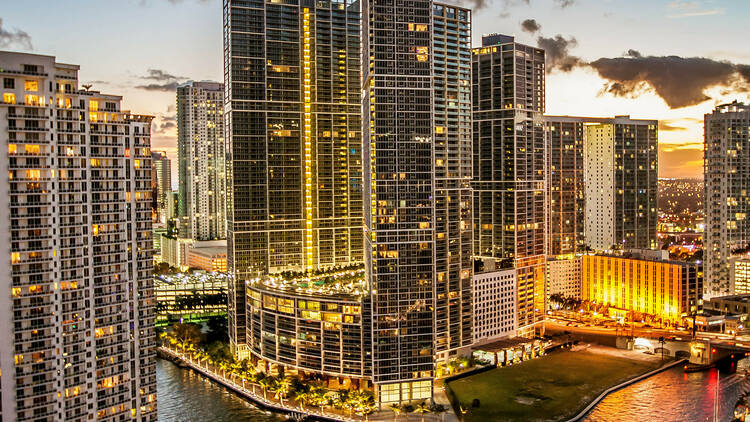

 <br></br>
##     <Center> Index  </Center>  
 <br></br>
####     0. PACKAGE LOADING
####     1. IMPORTING AND FILTERING DATA
####     2. ADDING RATIOS, LEAD AND LAG VARIABLES
####     3. CREATING MAIN PROJECT DATAFRAME DICTIONARY
####     4. MODEL: OLS ROLLING WINDOW REGRESSIONS
####     5. MODEL: MOMENTUM STRATEGY LONG BEST CITIES
####     6. MODEL: MOMENTUM STRATEGY SHORT LOW RET. CITIES 
####     7. MODEL: MOMENTUM STRATEGY LONG LOW RET. CITIES 
####     8. MODEL: OLS ROLLING WINDOW REGRESSIONS
####     9. MACHINE LEARNING MODELS TO EVALUATE LISTING PRICES AND RENTAL PRICES CORRELATION

 <br></br>
  <br></br>

####    <Center> 0. PACKAGE LOADING   </Center> 
<br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import numpy as np
import scipy.stats as stats
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import sklearn.tree as tree
import sklearn.ensemble as ensemble


 <br></br>
####  <Center>    1.0 IMPORTING AND FILTERING DATA </Center> 
####  <Center>    Importing city data fron Zillow:  https://www.kaggle.com/datasets/zillow/zecon - City_time_series.csv </Center> 
 <br></br>

In [2]:
#city_data = pd.read_csv('C:/Users/rodri/Desktop/RUNIM5ML/CS/City_time_series.csv',skiprows=0 )

In [3]:
# Selecting interest columns and removing nan values
#city_data2 = city_data[['Date', 'RegionName', 'InventoryRaw_AllHomes','MedianListingPrice_AllHomes', 
# 'MedianRentalPrice_AllHomes', 'Sale_Counts' ]].copy()

In [4]:
#city_data_df = city_data2.dropna()
#city_data_df.to_pickle('C:/Users/rodri/Desktop/RUNIM5ML/CS/city_data_df3') 

In [5]:
#Loading pickle 
city_data_df = pd.read_pickle('C:/Users/rodri/Desktop/RUNIM5ML/CS/city_data_df3') 

 <br></br>
####  <Center>    2.0 ADDING RATIOS, LAG AND LEAD VARIABLES </Center> 
 <br></br>

In [6]:
# Adding Variables for sales to inventory ratio and pct change of this variable
city_data_df['Sales to Inv Ratio'] =  city_data_df['Sale_Counts']/city_data_df['InventoryRaw_AllHomes']
city_data_df['Date'] = pd.to_datetime(city_data_df['Date'])
city_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33721 entries, 2210136 to 3762538
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         33721 non-null  datetime64[ns]
 1   RegionName                   33721 non-null  object        
 2   InventoryRaw_AllHomes        33721 non-null  float64       
 3   MedianListingPrice_AllHomes  33721 non-null  float64       
 4   MedianRentalPrice_AllHomes   33721 non-null  float64       
 5   Sale_Counts                  33721 non-null  float64       
 6   Sales to Inv Ratio           33721 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.1+ MB


In [7]:
# Adding lag variables for rental and listing price changes 1 to n-1 periods
for i in range (1,4):
    city_data_df['Listing Price Change ' +  str(i) + 'P'] =city_data_df.groupby('RegionName')['MedianListingPrice_AllHomes'].pct_change(i)
    city_data_df['Rental Price Change ' +  str(i) + 'P'] = city_data_df.groupby('RegionName')['MedianRentalPrice_AllHomes'].pct_change(i)
    city_data_df[('Sales to Inv Change ' +  str(i) + 'P')] =  city_data_df.groupby('RegionName')['Sales to Inv Ratio'].pct_change(i)
    

In [8]:
city_data_df.head(5)

,Date,RegionName,InventoryRaw_AllHomes,MedianListingPrice_AllHomes,MedianRentalPrice_AllHomes,Sale_Counts,Sales to Inv Ratio,Listing Price Change 1P,Rental Price Change 1P,Sales to Inv Change 1P,Listing Price Change 2P,Rental Price Change 2P,Sales to Inv Change 2P,Listing Price Change 3P,Rental Price Change 3P,Sales to Inv Change 3P
2210136,2010-02-28,arlingtonarlingtonva,600.0,484900.0,1600.0,149.0,0.248333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2211994,2010-02-28,chesapeakechesapeake_cityva,2134.0,265000.0,1437.5,141.0,0.066073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2220564,2010-02-28,raleighwakenc,4012.0,212625.0,1100.0,301.0,0.075025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2223818,2010-02-28,virginia_beachvirginia_beach_cityva,3679.0,250000.0,1300.0,284.0,0.077195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2225382,2010-03-31,arlingtonarlingtonva,660.0,489000.0,1700.0,222.0,0.336364,0.008455,0.0625,0.354484,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Adding Lead Variables 
# This will be the Y variable in the regression model set that will be run with ['Listing Price ChangeLead 1P'] as Y
# another set of models will be run with ['Rental Price Change Lead 1P'] a Ycity_data_df['Listing Price ChangeLead 1P'] =city_data_df.groupby('RegionName')['Listing Price Change 1P'].shift(-1)
city_data_df['Listing Price ChangeLead 1P'] =city_data_df.groupby('RegionName')['Listing Price Change 1P'].shift(-1)
city_data_df['Rental Price Change Lead 1P'] = city_data_df.groupby('RegionName')['Rental Price Change 1P'].shift(-1)
city_data_df = city_data_df.dropna() 

In [10]:
city_data_df.head(5)

,Date,RegionName,InventoryRaw_AllHomes,MedianListingPrice_AllHomes,MedianRentalPrice_AllHomes,Sale_Counts,Sales to Inv Ratio,Listing Price Change 1P,Rental Price Change 1P,Sales to Inv Change 1P,Listing Price Change 2P,Rental Price Change 2P,Sales to Inv Change 2P,Listing Price Change 3P,Rental Price Change 3P,Sales to Inv Change 3P,Listing Price ChangeLead 1P,Rental Price Change Lead 1P
2256279,2010-05-31,arlingtonarlingtonva,773.0,499500.0,1900.0,325.0,0.420440,0.019596,0.014415,0.220531,0.021472,0.117647,0.249956,0.030109,0.187500,0.693046,-0.019219,0.052632
2258165,2010-05-31,chesapeakechesapeake_cityva,2292.0,255000.0,1450.0,212.0,0.092496,-0.018853,0.054545,0.015291,-0.019023,0.039427,0.252701,-0.037736,0.008696,0.399899,-0.019608,0.034483
2266878,2010-05-31,raleighwakenc,4328.0,209900.0,1195.0,649.0,0.149954,0.000000,0.039130,0.090908,0.000000,0.086364,0.220554,-0.012816,0.086364,0.998720,0.000000,0.020921
2270165,2010-05-31,virginia_beachvirginia_beach_cityva,4242.0,255000.0,1350.0,497.0,0.117162,0.000392,0.000000,-0.019331,0.012306,0.042471,0.034842,0.020000,0.038462,0.517739,-0.000541,0.000000
2271740,2010-06-30,arlingtonarlingtonva,818.0,489900.0,2000.0,266.0,0.325183,-0.019219,0.052632,-0.226564,0.000000,0.067806,-0.055998,0.001840,0.176471,-0.033239,0.000000,0.098750


 <br></br> 
 ##### <Center>  3.0 CREATING MAIN PROJECT DATAFRAME DICTIONARY </Center> 
  <br></br>

In [11]:
city_data_df['_Date_'] = city_data_df['Date']
city_data_df= city_data_df.set_index('Date')


In [12]:
#%% City Dictionary for all cities
city_dict = dict()
for i in city_data_df['RegionName'].unique():
        city_dict[i] = city_data_df[(city_data_df['RegionName'] == i)]
        

In [13]:
#%% City Dictionary for all cities with 60 or more months of data - 
city_dict_MY = dict()
for i in city_data_df['RegionName'].unique():
    if (len(city_dict[i])) >=  59:
        city_dict_MY[i] = city_data_df[(city_data_df['RegionName'] == i  )]


In [14]:
#%% City Name Dictionary for selected cities with 60 or more months of data - 
city_name_dict_MY = dict()
for i in city_dict_MY:    
        city_name_dict_MY[i] = i
                 

In [15]:
#%% tables of all listing price changes from previous period for each city
Listing_price_chg_1L = pd.DataFrame()
for city in city_name_dict_MY: 
    column_name = city
    Listing_price_chg_1L[city] = city_dict_MY[city]['Listing Price ChangeLead 1P'] 
    Listing_price_chg_1L['Benchmark'] = Listing_price_chg_1L.mean(axis=1)    


 <br></br>
 #### <Center> 4.0 MODEL SET 1 - Rolling Window OLS REGRESSIONS Y = Listing price percentage change 1 Period ahead. </Center> <br>
 #### <Center> CREATING A TRADING STRATEGY USING THE HIGHEST PREDICTED K CITIES NEXT PERIODS AS CITIES TO INVEST IN  </Center>
                   
                   


In [16]:
#%% Rolling out of sample OLS performance
window = 24
X_all = Listing_price_chg_1L
OLS_pred_OOS = pd.DataFrame(index=X_all.index,columns=(city_name_dict_MY.keys()))


In [17]:

for city in city_name_dict_MY:
    #print(city)
    XX = city_dict_MY[city][['Sales to Inv Ratio', 
       'Rental Price Change 1P', 'Sales to Inv Change 1P', 'Rental Price Change 2P', 'Sales to Inv Change 2P', 
       'Rental Price Change 3P', 'Sales to Inv Change 3P']]
    for t in range(0,47-window-1, 1):
        #print(city,' iteration ', t , '/', (47-window-1))
        X = XX.iloc[t:(t+window)]
        Y = city_dict_MY[city]['Listing Price ChangeLead 1P'].iloc[t:(t+window)]
        model = sm.OLS(Y,sm.add_constant(X))
        results = model.fit()
        X_oos = XX.iloc[t+window:t+window+1]
        X_oos.insert(0, "const", 1, True)
        ypred = results.predict(X_oos) 
        OLS_pred_OOS.loc[X_all.index[t+window+1]][city] = ypred[0]
        
OLS_pred_OOS = OLS_pred_OOS.astype(float)
OLS_pred_OOS = OLS_pred_OOS.dropna()


Benchmark Mean  0.11274257428218631  SD  0.06897794668270026  SR  1.634472751136013
Strat Mean  0.11193705315043118  SD  0.11394083160132082  SR  0.9824138684725343


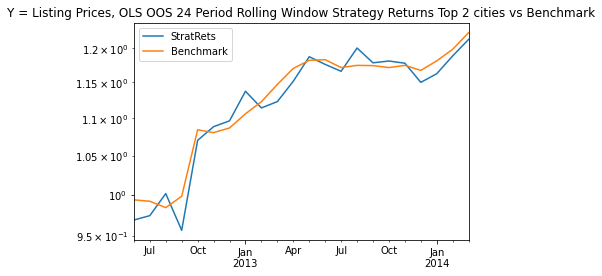

In [18]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 2
Highest_Pred = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred[col_name] = OLS_pred_OOS.T.apply(lambda x: x.nlargest(i).idxmin())

loc = Listing_price_chg_1L.columns.get_loc  
OLS_OOS_Strat_Rets = pd.Series(dtype='float64')
for d in Highest_Pred.index:
    Cols = Highest_Pred[d:d]  
    Mean_rets = Listing_price_chg_1L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    OLS_OOS_Strat_Rets = OLS_OOS_Strat_Rets.append(Mean_rets)
OLS_OOS_Strat_Rets = pd.DataFrame({'StratRets':OLS_OOS_Strat_Rets})

OLS_OOS_Strat_Rets = pd.merge(OLS_OOS_Strat_Rets, Listing_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
OLS_OOS_Strat_Rets.add(1).cumprod().plot(logy = True, title = 'Y = Listing Prices, OLS OOS ' + str(window) +' Period Rolling Window Strategy Returns Top ' + str(K) + ' cities vs Benchmark')    
print('Benchmark Mean ', OLS_OOS_Strat_Rets['Benchmark'].mean()*12,' SD ', OLS_OOS_Strat_Rets['Benchmark'].std()*(12**.5), ' SR ', (OLS_OOS_Strat_Rets['Benchmark'].mean()*12)/(OLS_OOS_Strat_Rets['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', OLS_OOS_Strat_Rets['StratRets'].mean()*12,' SD ', OLS_OOS_Strat_Rets['StratRets'].std()*(12**.5), ' SR ', (OLS_OOS_Strat_Rets['StratRets'].mean()*12)/(OLS_OOS_Strat_Rets['StratRets'].std()*(12**.5)))    


In [19]:
Rettest_OOS_OLS = OLS_OOS_Strat_Rets.add(1).cumprod()   

 <br></br> 
 #### <Center> 5.0 MODEL SET 2 - Price Momentum Strategy Y = Listing price percentage change 1 Period ahead.</Center> 
 #### <Center> CREATING A TRADING STRATEGY USING THE CITY WITH THE HIGHEST PRICE APPRECIATION PREVIOUS X PERIODS AND INVESTING LONG IN THIS CITIES FOR THE NEXT PERIOD  </Center>
 <br></br>

In [20]:
Listing_price_chg = pd.DataFrame()
for city in city_name_dict_MY: 
    column_name = city
    Listing_price_chg[city] = city_dict_MY[city]['Listing Price Change 1P'] 
        
Listing_price_chg_bnmk = pd.DataFrame()
for city in city_name_dict_MY: 
    column_name = city
    Listing_price_chg_bnmk[city] = city_dict_MY[city]['Listing Price Change 1P'] 
    Listing_price_chg_bnmk['Benchmark'] = Listing_price_chg_bnmk.mean(axis=1)    



In [21]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 1
Highest_Pred_MOM = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred_MOM[col_name] = Listing_price_chg.T.apply(lambda x: x.nlargest(i).idxmin())


In [22]:
Strat_Rets_MOM = pd.Series(dtype='float64')
loc = Listing_price_chg_bnmk.columns.get_loc

for d in Highest_Pred_MOM.index:
    Cols = Highest_Pred_MOM[d:d]  
    Mean_rets_MOM = Listing_price_chg_1L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    Strat_Rets_MOM = Strat_Rets_MOM.append(Mean_rets_MOM)
Strat_Rets_MOM = pd.DataFrame({'Momentum StratRets':Strat_Rets_MOM})

In [23]:
RettestMOM = Strat_Rets_MOM.add(1).cumprod()  

Benchmark Mean  0.048224043567621576  SD  0.04909488047966769  SR  0.9822621645365496
Strat Mean  0.033361202591425776  SD  0.1437187143625442  SR  0.23212845132519733


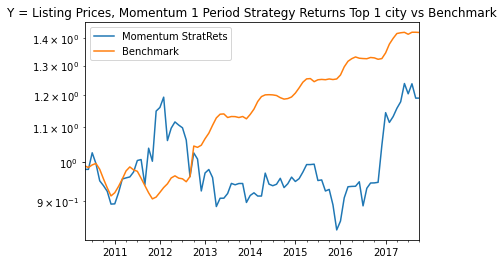

In [24]:

Strat_Rets_MOM = pd.merge(Strat_Rets_MOM, Listing_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
Strat_Rets_MOM.add(1).cumprod().plot(logy=True ,title = 'Y = Listing Prices, Momentum ' + str() +'1 Period Strategy Returns Top ' + str(K) + ' city vs Benchmark')    
print('Benchmark Mean ', Strat_Rets_MOM['Benchmark'].mean()*12,' SD ', Strat_Rets_MOM['Benchmark'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Benchmark'].mean()*12)/(Strat_Rets_MOM['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', Strat_Rets_MOM['Momentum StratRets'].mean()*12,' SD ',Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Momentum StratRets'].mean()*12)/(Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5)))    


  <br></br>
 #### <Center> 5.1 MODEL SET 2 - Price Momentum Strategy Y = Listing price percentage change 1 Period ahead. </Center> 
 #### <Center> CREATING A TRADING STRATEGY USING THE CITIES WITH THE HIGHEST PRICE APPRECIATION/DEPRECIATION PREVIOUS X PERIODS AND INVESTING LONG/SHORT IN THESE CITIES FOR THE NEXT PERIOD  </Center>
 
 <br></br>

In [25]:
# Variable for defining the number of looking back momentum periods
# the best or worst performers for the past x months

In [26]:
momentum_periods = 11

In [27]:
Listing_prine_chg_MOM = Listing_price_chg_bnmk.add(1).cumprod()   
Listing_price_chg_MOM_4 = Listing_prine_chg_MOM.shift(-momentum_periods+1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4.drop(['Benchmark'], axis=1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4[:-momentum_periods+1]
Listing_price_chg_4L = Listing_price_chg_1L.shift(-momentum_periods+1)

In [28]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 6
Highest_Pred_MOM = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred_MOM[col_name] = Listing_price_chg_MOM_4.T.apply(lambda x: x.nlargest(i).idxmin())
    

In [29]:
Strat_Rets_MOM = pd.Series(dtype='float64')
loc = Listing_price_chg_bnmk.columns.get_loc
for d in Highest_Pred_MOM.index:
    Cols = Highest_Pred_MOM[d:d]  
    Mean_rets_MOM = Listing_price_chg_4L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    Strat_Rets_MOM = Strat_Rets_MOM.append(Mean_rets_MOM)
Strat_Rets_MOM = pd.DataFrame({'Momentum StratRets':Strat_Rets_MOM})

In [30]:
RettestMOM = Strat_Rets_MOM.add(1).cumprod() 

Benchmark Mean  0.04352595367305043  SD  0.05076481793882965  SR  0.8574039155522655
Strat Mean  0.025366907212175827  SD  0.06418178887969396  SR  0.39523527865084934


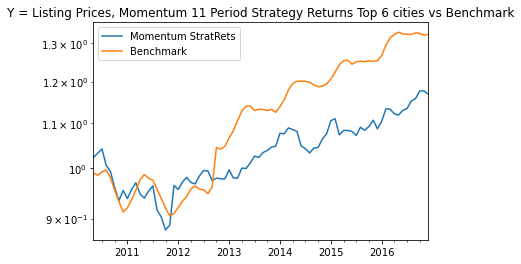

In [31]:
Strat_Rets_MOM = pd.merge(Strat_Rets_MOM, Listing_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
Strat_Rets_MOM.add(1).cumprod().plot(logy=True ,title = 'Y = Listing Prices, Momentum ' + str(momentum_periods) +' Period Strategy Returns Top ' + str(K) + ' cities vs Benchmark')    
print('Benchmark Mean ', Strat_Rets_MOM['Benchmark'].mean()*12,' SD ', Strat_Rets_MOM['Benchmark'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Benchmark'].mean()*12)/(Strat_Rets_MOM['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', Strat_Rets_MOM['Momentum StratRets'].mean()*12,' SD ',Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Momentum StratRets'].mean()*12)/(Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5)))    


 <br></br>
 #### <Center> 6.0 MODEL SET 2 - Price Momentum Strategy Y = Listing price percentage change 1 Period ahead. </Center> 
 #### <Center> CREATING A TRADING STRATEGY USING THE CITIES WITH THE HIGHEST PRICE DEPRECIATION PREVIOUS X PERIODS AND INVESTING SHORT IN THESE CITIES FOR THE NEXT PERIOD </Center>
  <br></br>

In [32]:
momentum_periods = 11

In [33]:
Listing_prine_chg_MOM = Listing_price_chg_bnmk.add(1).cumprod()   
Listing_price_chg_MOM_4 = Listing_prine_chg_MOM.shift(-momentum_periods+1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4.drop(['Benchmark'], axis=1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4[:-momentum_periods+1]
Listing_price_chg_4L = Listing_price_chg_1L.shift(-momentum_periods+1)

In [34]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 3
Highest_Pred_MOM = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred_MOM[col_name] = Listing_price_chg_MOM_4.T.apply(lambda x: x.nsmallest(i).idxmin())
    # Listing_price_chg.T.apply(lambda x: x.nlargest(i).idxmin())

In [35]:
 
Strat_Rets_MOM = pd.Series(dtype='float64')
loc = Listing_price_chg_bnmk.columns.get_loc
for d in Highest_Pred_MOM.index:
    Cols = Highest_Pred_MOM[d:d]  
    Mean_rets_MOM = Listing_price_chg_4L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    Strat_Rets_MOM = Strat_Rets_MOM.append(Mean_rets_MOM) * -1
Strat_Rets_MOM = pd.DataFrame({'Momentum StratRets':Strat_Rets_MOM})


In [36]:
RettestMOM = Strat_Rets_MOM.add(1).cumprod()   

Benchmark Mean  0.04352595367305043  SD  0.05076481793882965  SR  0.8574039155522655
Strat Mean  -0.04178797161351683  SD  0.14351809378361743  SR  -0.29116866390742796


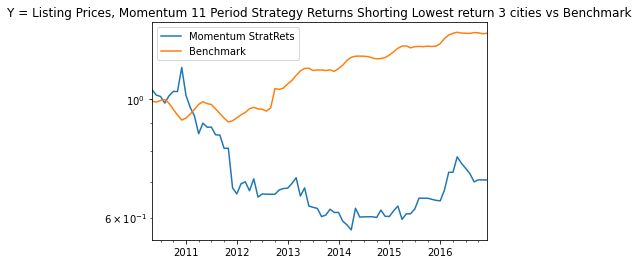

In [37]:
Strat_Rets_MOM = pd.merge(Strat_Rets_MOM, Listing_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
Strat_Rets_MOM.add(1).cumprod().plot(logy=True ,title = 'Y = Listing Prices, Momentum ' + str(momentum_periods) +' Period Strategy Returns Shorting Lowest return ' + str(K) + ' cities vs Benchmark')    
print('Benchmark Mean ', Strat_Rets_MOM['Benchmark'].mean()*12,' SD ', Strat_Rets_MOM['Benchmark'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Benchmark'].mean()*12)/(Strat_Rets_MOM['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', Strat_Rets_MOM['Momentum StratRets'].mean()*12,' SD ',Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Momentum StratRets'].mean()*12)/(Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5)))    


 <br></br>
 #### <Center> 7.0 MODEL SET 2 - Price Momentum Strategy Y = Listing price percentage change 1 Period ahead. </Center> 
 #### <Center> CREATING A TRADING STRATEGY USING THE CITIES WITH THE HIGHEST PRICE DEPRECIATION PREVIOUS X PERIODS AND INVESTING LONG IN THESE CITIES FOR THE NEXT PERIOD </Center>
  <br></br>

In [38]:
momentum_periods = 11

In [39]:
Listing_prine_chg_MOM = Listing_price_chg_bnmk.add(1).cumprod()   
Listing_price_chg_MOM_4 = Listing_prine_chg_MOM.shift(-momentum_periods+1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4.drop(['Benchmark'], axis=1)
Listing_price_chg_MOM_4 = Listing_price_chg_MOM_4[:-momentum_periods+1]
Listing_price_chg_4L = Listing_price_chg_1L.shift(-momentum_periods+1)


In [40]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 3
Highest_Pred_MOM = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred_MOM[col_name] = Listing_price_chg_MOM_4.T.apply(lambda x: x.nsmallest(i).idxmin())
    # Listing_price_chg.T.apply(lambda x: x.nlargest(i).idxmin())

In [41]:
Strat_Rets_MOM = pd.Series(dtype='float64')
loc = Listing_price_chg_bnmk.columns.get_loc
for d in Highest_Pred_MOM.index:
    Cols = Highest_Pred_MOM[d:d]  
    Mean_rets_MOM = Listing_price_chg_4L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    Strat_Rets_MOM = Strat_Rets_MOM.append(Mean_rets_MOM) 
Strat_Rets_MOM = pd.DataFrame({'Momentum StratRets':Strat_Rets_MOM})
 

In [42]:
RettestMOM = Strat_Rets_MOM.add(1).cumprod()    

Benchmark Mean  0.04352595367305043  SD  0.05076481793882965  SR  0.8574039155522655
Strat Mean  0.14377519468824546  SD  0.13784190491569603  SR  1.0430441655328124


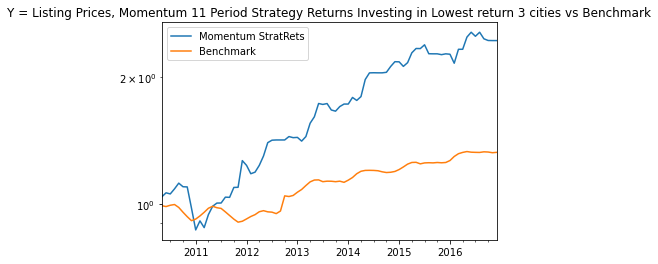

In [43]:
Strat_Rets_MOM = pd.merge(Strat_Rets_MOM, Listing_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
Strat_Rets_MOM.add(1).cumprod().plot(logy=True ,title = 'Y = Listing Prices, Momentum ' + str(momentum_periods) +' Period Strategy Returns Investing in Lowest return ' + str(K) + ' cities vs Benchmark')    
print('Benchmark Mean ', Strat_Rets_MOM['Benchmark'].mean()*12,' SD ', Strat_Rets_MOM['Benchmark'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Benchmark'].mean()*12)/(Strat_Rets_MOM['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', Strat_Rets_MOM['Momentum StratRets'].mean()*12,' SD ',Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5), ' SR ', (Strat_Rets_MOM['Momentum StratRets'].mean()*12)/(Strat_Rets_MOM['Momentum StratRets'].std()*(12**.5)))    


 <br></br>
 #### <Center> 8.0 MODEL SET 3 - Rolling Window OLS REGRESSIONS Y = Rental Price percentage change 1 Period ahead. </Center> 
 #### <Center>CREATING A TRADING STRATEGY USING THE HIGHEST PREDICTED K CITIES NEXT PERIODS AS CITIES TO INVEST IN </Center>

In [44]:
# tables of all rental price changes from previous period for each city
Rental_price_chg_1L = pd.DataFrame()
for city in city_name_dict_MY: 
    column_name = city
    Rental_price_chg_1L[city] = city_dict_MY[city]['Rental Price Change Lead 1P'] 
    Rental_price_chg_1L['Benchmark'] = Rental_price_chg_1L.mean(axis=1)  

In [45]:
# Rolling out of sample OLS performance
window = 24
X_all = Rental_price_chg_1L
OLS_pred_OOS = pd.DataFrame(index=X_all.index,columns=(city_name_dict_MY.keys()))


In [46]:
for city in city_name_dict_MY:
    #print(city)
    XX = city_dict_MY[city][['Sales to Inv Ratio', 
       'Listing Price Change 1P', 'Listing Price Change 2P', 
       'Listing Price Change 3P', ]]
    for t in range(0,47-window-1, 1):
        #print(city,' iteration ', t , '/', (47-window-1))
        X = XX.iloc[t:(t+window)]
        Y = city_dict_MY[city]['Rental Price Change Lead 1P'].iloc[t:(t+window)]
        model = sm.OLS(Y,sm.add_constant(X))
        results = model.fit()
        X_oos = XX.iloc[t+window:t+window+1]
        X_oos.insert(0, "const", 1, True)
        ypred = results.predict(X_oos) 
        OLS_pred_OOS.loc[X_all.index[t+window+1]][city] = ypred[0]
        
OLS_pred_OOS = OLS_pred_OOS.astype(float)
OLS_pred_OOS = OLS_pred_OOS.dropna()

Benchmark Mean  0.018183666449177502  SD  0.028686320706428108  SR  0.633879354388688
Strat Mean  0.16740348781417497  SD  0.1385623121252482  SR  1.2081458893588386


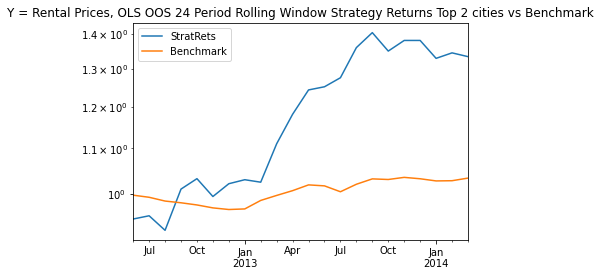

In [47]:
#%% Calculating strategy returns K = number of selected cities to invest in
K = 2
Highest_Pred = pd.DataFrame()
for i in range(1,K+1):
    col_name = 'high'+str(i)
    Highest_Pred[col_name] = OLS_pred_OOS.T.apply(lambda x: x.nlargest(i).idxmin())

loc = Rental_price_chg_1L.columns.get_loc  
OLS_OOS_Strat_Rets = pd.Series(dtype='float64')
for d in Highest_Pred.index:
    Cols = Highest_Pred[d:d]  
    Mean_rets = Rental_price_chg_1L[d:d].iloc[:, Cols.iloc[0,:].apply(lambda x: loc(x))].mean(axis=1)
    OLS_OOS_Strat_Rets = OLS_OOS_Strat_Rets.append(Mean_rets)
OLS_OOS_Strat_Rets = pd.DataFrame({'StratRets':OLS_OOS_Strat_Rets})

OLS_OOS_Strat_Rets = pd.merge(OLS_OOS_Strat_Rets, Rental_price_chg_1L['Benchmark'], left_index=True, right_index=True, how='left')   
OLS_OOS_Strat_Rets.add(1).cumprod().plot(logy=True ,title = 'Y = Rental Prices, OLS OOS ' + str(window) +' Period Rolling Window Strategy Returns Top ' + str(K) + ' cities vs Benchmark')    
print('Benchmark Mean ', OLS_OOS_Strat_Rets['Benchmark'].mean()*12,' SD ', OLS_OOS_Strat_Rets['Benchmark'].std()*(12**.5), ' SR ', (OLS_OOS_Strat_Rets['Benchmark'].mean()*12)/(OLS_OOS_Strat_Rets['Benchmark'].std()*(12**.5)))    
print('Strat Mean ', OLS_OOS_Strat_Rets['StratRets'].mean()*12,' SD ', OLS_OOS_Strat_Rets['StratRets'].std()*(12**.5), ' SR ', (OLS_OOS_Strat_Rets['StratRets'].mean()*12)/(OLS_OOS_Strat_Rets['StratRets'].std()*(12**.5)))    


 <br></br>
 #### <Center> 9.0 - CORRELATION BETWEEN LISTING AND RENTAL PRICES </Center> 
 #### <Center>CREATING A SEVERAL MACHINE LEARNING MODELS TO EVALUTA CORRELATION </Center>

In [48]:
city_data_df = pd.read_pickle('C:/Users/rodri/Desktop/RUNIM5ML/CS/city_data_df3') 

In [49]:
#Adding Variables for sales to inventory ratio and pct change of this variable
city_data_df['Sales to Inv Ratio'] =  city_data_df['Sale_Counts']/city_data_df['InventoryRaw_AllHomes']


In [50]:
#
city_data_df['Date'] = pd.to_datetime(city_data_df['Date'])


In [51]:
city_data_df['Date'] = city_data_df['Date'].dt.date 


In [52]:
city_data_df['Date'] = pd.to_datetime(city_data_df['Date'] ).dt.date


In [53]:
# Adding lag variables for rental and listing price changes 1 to 12 periods
# Adding lag variables for sale count to inventory ratio changes
for i in range (1,13):
    city_data_df['Listing Price Change ' +  str(i) + 'P'] =city_data_df.groupby('RegionName')['MedianListingPrice_AllHomes'].pct_change(i)
    city_data_df['Rental Price Change ' +  str(i) + 'P'] = city_data_df.groupby('RegionName')['MedianRentalPrice_AllHomes'].pct_change(i)
    city_data_df[('Sales to Inv Change ' +  str(i) + 'P')] =  city_data_df.groupby('RegionName')['Sales to Inv Ratio'].pct_change(i)
    

In [54]:
# Adding Lead Variables 
# This will be the Y variables one model will be run with ['Listing Price ChangeLead 1P'] as Y
# and another model will be run with ['Rental Price Change Lead 1P'] a Y

city_data_df['Listing Price ChangeLead 1P'] =city_data_df.groupby('RegionName')['Listing Price Change 1P'].shift(-1)
city_data_df['Rental Price Change Lead 1P'] = city_data_df.groupby('RegionName')['Rental Price Change 1P'].shift(-1)


In [55]:
#City Dictionary for all cities
city_dict = dict()
for i in city_data_df['RegionName'].unique():
        city_dict[i] = city_data_df[(city_data_df['RegionName'] == i)]

In [56]:
#City Dictionary for all cities with 24 or more months of data - only 553 cities have data for more than 2 years
city_dict_2y = dict()
for i in city_data_df['RegionName'].unique():
    if (len(city_dict[i])) >=  23:
        city_dict_2y[i] = city_data_df[(city_data_df['RegionName'] == i  )]
        

In [57]:
#Defining Main Dataframe

pd_city_data = city_data_df[['InventoryRaw_AllHomes',
       'MedianListingPrice_AllHomes', 'MedianRentalPrice_AllHomes',
       'Sale_Counts', 'Sales to Inv Ratio', 'Listing Price Change 1P',
       'Rental Price Change 1P', 'Sales to Inv Change 1P',
       'Listing Price Change 2P', 'Rental Price Change 2P',
       'Sales to Inv Change 2P', 'Listing Price Change 3P',
       'Rental Price Change 3P', 'Sales to Inv Change 3P',
       'Listing Price Change 4P', 'Rental Price Change 4P',
       'Sales to Inv Change 4P', 'Listing Price Change 5P',
       'Rental Price Change 5P', 'Sales to Inv Change 5P',
       'Listing Price Change 6P', 'Rental Price Change 6P',
       'Sales to Inv Change 6P', 'Listing Price Change 7P',
       'Rental Price Change 7P', 'Sales to Inv Change 7P',
       'Listing Price Change 8P', 'Rental Price Change 8P',
       'Sales to Inv Change 8P', 'Listing Price Change 9P',
       'Rental Price Change 9P', 'Sales to Inv Change 9P',
       'Listing Price Change 10P', 'Rental Price Change 10P',
       'Sales to Inv Change 10P', 'Listing Price Change 11P',
       'Rental Price Change 11P', 'Sales to Inv Change 11P',
       'Listing Price Change 12P', 'Rental Price Change 12P',
       'Sales to Inv Change 12P', 'Listing Price ChangeLead 1P',
       'Rental Price Change Lead 1P' ]].copy()

In [58]:
# Dropping Na Values
pd_city_data = pd_city_data.dropna()

 <br></br>
 #### <Center> 9.1 - CORRELATION BETWEEN LISTING AND RENTAL PRICES </Center> 
 #### <Center>Sales Prices changes are dependant on Rental prices changes 12 lags </Center>

In [59]:
# Splitting Data into X data and Y Data 
x_df = pd_city_data.drop(['Listing Price ChangeLead 1P','Rental Price Change Lead 1P' ], axis=1)
y_series = pd_city_data['Listing Price ChangeLead 1P']

In [60]:
# Splitting into Test and Train Data
x_train, x_test, y_train, y_test \
    = model_selection.train_test_split(x_df, y_series, test_size = 1/3.0, random_state=0)


In [61]:
# Function for model prediction analysis
def get_predictive_corr(sklearn_model, x, y):
    y_pred = pd.Series(
        data=sklearn_model.predict(x),
        index=y.index)
   
    return y.corr(y_pred)

In [62]:
# Class for keeping track and printing each models results

class ModelRatings:
  
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.all_results = {}
    
    def display_results(self):
        return pd.DataFrame(self.all_results).round(2)
    
    def add_model(self, sklearn_model, name):
        self.all_results[name] = {
            'Listing Prices Change 1 Period =  Y, 12 Lags: Test Score**': get_predictive_corr(
                sklearn_model, self.x_test, self.y_test), 
            'Listing Prices Change 1 Period =  Y, 12 Lags Training Score' : get_predictive_corr(
                sklearn_model, self.x_train, self.y_train),
        }
        return self.display_results()

model_ratings = ModelRatings(x_train, x_test, y_train, y_test)

In [63]:
#  Model 1 - OLS
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
model_ratings.add_model(linear_regression, '1) Classic Linear Regression')  

,1) Classic Linear Regression
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.25
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.24


In [64]:
# Model 2 - Lasso
lasso_cv = linear_model.LassoCV(random_state=0, cv=3)
lasso_cv.fit(x_train, y_train)
model_ratings.add_model(lasso_cv, '2) Lasso Regression')

,1) Classic Linear Regression,2) Lasso Regression
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.24,0.02
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.25,0.04


In [65]:
# Model 3 - Ridge

import sklearn.linear_model as linear_model
ridge_cv = linear_model.RidgeCV()
ridge_cv.fit(x_train, y_train)
model_ratings.add_model(ridge_cv, '3) Ridge Regression')


,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.24,0.02,0.24
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.25,0.04,0.25


In [66]:
# Model 4 - Elastic Net

from sklearn.linear_model import ElasticNet
ElasticNet = linear_model.ElasticNet()
ElasticNet.fit(x_train, y_train)
model_ratings.add_model(ElasticNet, '4) Elastic Net')



,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression,4) Elastic Net
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.24,0.02,0.24,0.02
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.25,0.04,0.25,0.04


In [67]:
resultsdf1 = pd.DataFrame(model_ratings.all_results) 
resultsdf1

,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression,4) Elastic Net
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.241950,0.021735,0.241570,0.021070
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.254422,0.038348,0.254188,0.035484


 <br></br>
 #### <Center> 9.2 - CORRELATION BETWEEN LISTING AND RENTAL PRICES </Center> 
 #### <Center>Rental Prices changes are dependant on Sales prices changes 12 lags </Center>

In [68]:
x_df = pd_city_data.drop(['Listing Price ChangeLead 1P',
       'Rental Price Change Lead 1P' ], axis=1)
y_series = pd_city_data['Rental Price Change Lead 1P']


In [69]:
# Splitting into Test and Train Data

x_train, x_test, y_train, y_test \
= model_selection.train_test_split(x_df, y_series, test_size = 1/3.0, random_state=0)

In [70]:
#%% Class for keeping track and printing each models results

class ModelRatings:
  
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.all_results = {}
    
    def display_results(self):
        return pd.DataFrame(self.all_results).round(2)
    
    def add_model(self, sklearn_model, name):
        self.all_results[name] = {
            'Rental Prices Change 1 Period =  Y, 12 Lags: Test Score**': get_predictive_corr(
                sklearn_model, self.x_test, self.y_test), 
            'Rental Prices Change 1 Period =  Y, 12 Lags Training Score' : get_predictive_corr(
                sklearn_model, self.x_train, self.y_train),
        }
        return self.display_results()

model_ratings = ModelRatings(x_train, x_test, y_train, y_test)

In [71]:
#%%  Model 1 - OLS

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
model_ratings.add_model(linear_regression, '1) Classic Linear Regression')  

,1) Classic Linear Regression
"Rental Prices Change 1 Period = Y, 12 Lags Training Score",0.41
"Rental Prices Change 1 Period = Y, 12 Lags: Test Score**",0.40


In [72]:
# Model 2 - Lasso

lasso_cv = linear_model.LassoCV(random_state=0, cv=3)
lasso_cv.fit(x_train, y_train)
model_ratings.add_model(lasso_cv, '2) Lasso Regression')


,1) Classic Linear Regression,2) Lasso Regression
"Rental Prices Change 1 Period = Y, 12 Lags: Test Score**",0.40,0.14
"Rental Prices Change 1 Period = Y, 12 Lags Training Score",0.41,0.07


In [73]:
# Model 3 - Ridge

import sklearn.linear_model as linear_model
ridge_cv = linear_model.RidgeCV()
ridge_cv.fit(x_train, y_train)
model_ratings.add_model(ridge_cv, '3) Ridge Regression')

,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression
"Rental Prices Change 1 Period = Y, 12 Lags: Test Score**",0.40,0.14,0.40
"Rental Prices Change 1 Period = Y, 12 Lags Training Score",0.41,0.07,0.41


In [74]:
# Model 4 - Elastic Net

from sklearn.linear_model import ElasticNet
ElasticNet = linear_model.ElasticNet()
ElasticNet.fit(x_train, y_train)
model_ratings.add_model(ElasticNet, '4) Elastic Net')

,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression,4) Elastic Net
"Rental Prices Change 1 Period = Y, 12 Lags: Test Score**",0.40,0.14,0.40,0.14
"Rental Prices Change 1 Period = Y, 12 Lags Training Score",0.41,0.07,0.41,0.07


In [75]:
resultsdf2 = pd.DataFrame(model_ratings.all_results) 

In [76]:
results_final = pd.concat([resultsdf1, resultsdf2], axis=0, )

In [77]:
results_final

,1) Classic Linear Regression,2) Lasso Regression,3) Ridge Regression,4) Elastic Net
"Listing Prices Change 1 Period = Y, 12 Lags: Test Score**",0.241950,0.021735,0.241570,0.021070
"Listing Prices Change 1 Period = Y, 12 Lags Training Score",0.254422,0.038348,0.254188,0.035484
"Rental Prices Change 1 Period = Y, 12 Lags: Test Score**",0.396019,0.140650,0.396476,0.141179
"Rental Prices Change 1 Period = Y, 12 Lags Training Score",0.409837,0.074575,0.409780,0.074307
